В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням kNearestNeighboors, знайдемо оптимальні гіперпараметри для цього методу і зробимо базові ансамблі. Це дасть змогу порівняти перформанс моделі з попередніми вивченими методами.

0. Зчитайте дані `train.csv` та зробіть препроцесинг використовуючи написаний Вами скрипт `process_bank_churn.py` так, аби в результаті отримати дані в розбитті X_train, train_targets, X_val, val_targets для експериментів.

  Якщо Вам не вдалось реалізувати в завданні `2.3. Дерева прийняття рішень` скрипт `process_bank_churn.py` - можна скористатись готовим скриптом з запропонованого рішення того завдання.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
%load_ext autoreload
%autoreload 2

from process_bank_churn import preprocess_data

train_dir = '../../../data/bank-customer-churn-prediction-dlu/train.csv'
test_dir = '../../../data/bank-customer-churn-prediction-dlu/test.csv'

train_val_df = pd.read_csv(train_dir)
data = preprocess_data(train_val_df);

X_train = data['train_X']
train_targets = data['train_y']
X_val = data['val_X']
val_targets = data['val_y']

X_train.head(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
8508,0.835322,0.321429,0.6,0.000000,0.333333,1.0,0.0,0.704456,1.0,0.0,0.0,1.0,0.0
8815,0.536993,0.535714,0.2,0.632928,0.000000,1.0,0.0,0.071038,0.0,1.0,0.0,1.0,0.0
11830,0.384248,0.464286,0.2,0.500472,0.000000,1.0,1.0,0.630413,0.0,1.0,0.0,1.0,0.0
10066,0.663484,0.339286,0.4,0.619047,0.333333,1.0,0.0,0.612534,0.0,1.0,0.0,1.0,0.0
9282,0.434368,0.464286,0.8,0.330907,0.333333,1.0,0.0,0.649829,1.0,0.0,0.0,1.0,0.0


1. Навчіть на цих даних класифікатор kNN з параметрами за замовченням і виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах. Зробіть заключення про отриману модель: вона хороша/погана, чи є high bias/high variance?

In [5]:
# k = 5
knn = KNeighborsClassifier().fit(X_train, train_targets)

AUROC for Training: 0.95


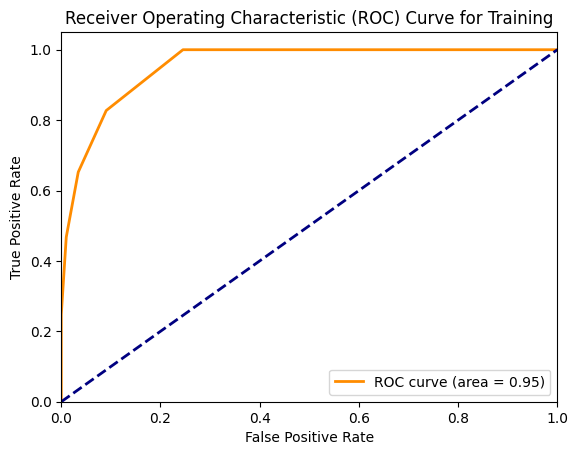

In [6]:
from process_bank_churn import count_and_plot_auroc
#  count_and_plot_auroc(model, inputs, targets, name='', plot=False) - моя функція для візуалізації з минулого дз, додала її в process_bank_churn для зручності перевикористання

count_and_plot_auroc(knn, X_train, train_targets, 'Training', plot=True)

AUROC for Validation: 0.85


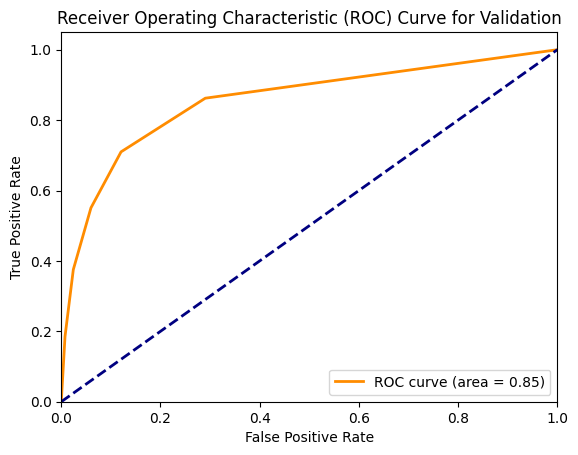

In [7]:
count_and_plot_auroc(knn, X_val, val_targets, 'Validation', plot=True)

Отримана модель набагато краще показує себе на тестових даних в порівнянні з валідаційними, що свідчить про перенавчання

2. Використовуючи `GridSearchCV` знайдіть оптимальне значення параметра `n_neighbors` для класифікатора `kNN`. Псотавте крос валідацію на 5 фолдів.

  Після успішного завершення пошуку оптимального гіперпараметра
    - виведіть найкраще значення параметра
    - збережіть в окрему змінну `knn_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `knn_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пукнтом (2) цього завдання? Чи є вона краще за дерево прийняття рішень з попереднього ДЗ?

In [8]:
knn_model = KNeighborsClassifier()
knn_params = {'n_neighbors': np.arange(1, 25)}
knn_grid = GridSearchCV(knn_model, knn_params, cv=5, n_jobs=5)
knn_grid.fit(X_train, train_targets)

knn_best = knn_grid.best_estimator_

print(knn_grid.best_params_, knn_grid.best_score_)


{'n_neighbors': 9} 0.86725


In [9]:
count_and_plot_auroc(knn_best, X_train, train_targets, 'Training')

AUROC for Training: 0.94


In [10]:
count_and_plot_auroc(knn_best, X_val, val_targets, 'Validation')


AUROC for Validation: 0.87


Отримана пошуком сіткою модель трохи краще показує себе на валідаційних даних, проте всеодно є перенавченою і дає результати значно гірші за дерево прийняття рішень з минулого дз(0.93 train, 0.92 val)

3. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `GridSearchCV` за сіткою параметрів
  - `max_depth` від 1 до 20 з кроком 2
  - `max_leaf_nodes` від 2 до 10 з кроком 1

  Обовʼязково при цьому ініціюйте модель з фіксацією `random_seed`.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `dt_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли вручну?

In [14]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(random_state=42)
tree_params = {'max_depth': np.arange(1, 20, 2),
               'max_leaf_nodes': np.arange(2, 10)}
tree_grid = GridSearchCV(tree_model, tree_params, cv = 3, scoring='roc_auc', n_jobs=5)

In [19]:
%%time
tree_grid.fit(X_train, train_targets)

CPU times: total: 234 ms
Wall time: 714 ms


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42), n_jobs=5,
             param_grid={'max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                         'max_leaf_nodes': array([2, 3, 4, 5, 6, 7, 8, 9])},
             scoring='roc_auc')

In [42]:
dt_best = tree_grid.best_estimator_

tree_grid.best_params_

{'max_depth': 5, 'max_leaf_nodes': 9}

In [43]:
count_and_plot_auroc(dt_best, X_train, train_targets, 'Training')

AUROC for Training: 0.90


In [44]:
count_and_plot_auroc(dt_best, X_val, val_targets, 'Validation')

AUROC for Validation: 0.89


Модель зі знайденими вручну в минулому дз з параметрами `max_leaf_nodes`=40, `max_depth`=6 показала себе краще отриманої пошукмом по сітці(0.93 на тренцвальних та 0.92 на вал. даних), адже GridSearch із значеннями до 40 був би дуже ресурсозатратним

4. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `RandomizedSearchCV` за заданою сіткою параметрів і кількість ітерацій 40.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, зафіксуйте `random_seed` процедури крос валідації та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_random_search_best` найкращу модель, знайдену з `RandomizedSearchCV`
    - оцініть якість передбачень  `dt_random_search_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли з `GridSearch`?
    - проаналізуйте параметри `dt_random_search_best` і порівняйте з параметрами `dt_best` - яку бачите відмінність? Ця вправа потрібна аби зрозуміти, як різні налаштування `DecisionTreeClassifier` впливають на якість моделі.

In [32]:
from sklearn.model_selection import RandomizedSearchCV

params_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(1, 20),
    # 'max_leaf_nodes': np.arange(2, 20),
    'max_leaf_nodes': np.arange(2, 60),
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}


dt_random = RandomizedSearchCV(tree_model, params_dt, scoring='roc_auc', random_state=42, cv=3, n_jobs=5, n_iter=40)

In [33]:
%%time
dt_random.fit(X_train, train_targets)

CPU times: total: 188 ms
Wall time: 314 ms


RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=40, n_jobs=5,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'max_leaf_nodes': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59]),
                                        'min_samples_leaf': [1, 2, 4, 8],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'splitter': ['best', 'random']},
                   random_state=42, scoring='roc_auc')

In [34]:
dt_random.best_params_

{'splitter': 'best',
 'min_samples_split': 20,
 'min_samples_leaf': 2,
 'max_leaf_nodes': 30,
 'max_features': None,
 'max_depth': 16,
 'criterion': 'entropy'}

In [30]:
dt_random_search_best = dt_random.best_estimator_

count_and_plot_auroc(dt_random_search_best, X_train, train_targets, 'Training')

AUROC for Training: 0.93


In [31]:
count_and_plot_auroc(dt_random_search_best, X_val, val_targets, 'Validation')


AUROC for Validation: 0.92


In [45]:
dt_best.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': 9,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

In [36]:
dt_random.best_params_

{'splitter': 'best',
 'min_samples_split': 20,
 'min_samples_leaf': 2,
 'max_leaf_nodes': 30,
 'max_features': None,
 'max_depth': 16,
 'criterion': 'entropy'}

Отримана модель дає кращі результати ніж модель з параметрами знайденими за допомогою GridSearch.

Значення параметрів моделі з парамерами RandomSearch відрізняються від параметрів GridSerach, так як в другому випадку вони взяті за замовчуванням, в той час як RandomSearch не потребує проходження по всіму простору значень парамерів і дає можливісь використати більше різноманітних значень для пошуку найкращих.

Значення параметрів що відрізняються:

* min_samples_split: 2/20
* min_samples_leaf: 1/2
* max_leaf_nodes: 9/30
* max_depth: 5/16
* criterion: gini/entropy

Отже вони є важливими для якості моделі дерева прийняття рішень

5. Якщо у Вас вийшла метрика `AUROC` в цій серії експериментів - зробіть ще один `submission` на Kaggle і додайте код для цього і скріншот скора на публічному лідерборді нижче.

  Сподіваюсь на цьому етапі ви вже відчули себе справжнім дослідником 😉

In [44]:
from process_bank_churn import preprocess_new_data

test_df = pd.read_csv(test_dir, index_col='id')

X_test = preprocess_new_data(test_df.copy(), data['encoder'], data['scaler'])

sample_submission_dir = '../../../data/bank-customer-churn-prediction-dlu/sample_submission.csv'
submission = pd.read_csv(sample_submission_dir, index_col=0)

test_preds = dt_random_search_best.predict_proba(X_test)[:, 1]
submission['Exited'] = test_preds

submission.to_csv('../../../data/bank-customer-churn-prediction-dlu/submissions/submission_tree_randsearch.csv')


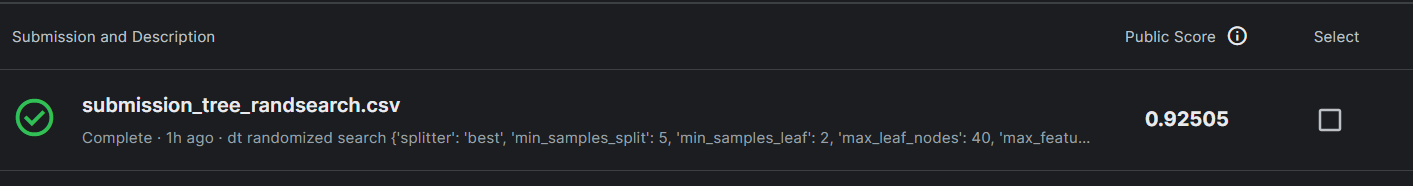